# Boekenclassificatie

Aan jou de taak om een neuraal netwerk te bouwen dat zo goed mogelijk kan voorspellen in welk genre een sample van een boek zich bevind. Laat met een cross validation matrix zien hoe goed je model zich gedraagt per genre.

## 1. Business Understanding

- Data van [Project Gutenberg](https://www.gutenberg.org/)
- [Bibliotheek van Congress-classificatie](https://www.loc.gov/catdir/cpso/lcc.html)

## 1.1. Aangeleverde data


## 1.2. Genres
De boeken zijn ingedeeld onder de volgende zeven genres:
|Genre                                              |Engelse Vertaling                              |Aantal boeken
|---------------------------------------------------|-----------------------------------------------|-------------
|Amerikaanse Literatuur                             |American Literature                            |4480
|Engelse Literatuur                                 |English Literature                             |4214
|Fictie en jeugdliteratuur                          |Fiction and juvenile belles lettres            |2624
|Geschiedenis van Europa, Azië, Afrika en Oceanië   |History of Europa, Asia, Africa and Oceania    |2071
|Filosofie, Psychologie en Religie                  |Philosophy, Psychology and Religion            |1550
|Taal en Literatuur                                 |Language and Literature                        |1264
|Tijdschriften                                      |Periodicals                                    |1132

## 2. Data Understanding

### 2.1. Importeren van benodigde pakketten

In [1]:
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer

import itertools
import numpy as np
import pandas as pd
import tensorflow as tf

2024-10-02 16:37:42.045216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 16:37:42.054838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 16:37:42.057716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 16:37:42.065838: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 16:37:42.657771: W tensorflow/compiler/tf2

### 2.2. Inspecteren van `training.csv`

In [2]:
training_df = pd.read_csv("Data/huiswerk/training.csv.gz")

Om een eerste blik te werpen op de traindata, gebruik ik de volgende methodes. Ik zie dat er zo’n 120 duizend regels zijn, elk met:
- Een `usage`-veld, waarschijnlijk voor `training.csv` alleen maar `train`, voor `testing.csv` alleen maar `testing`, etc.
- Een `main genre`-veld, dat waarschijnlijk overeenkomt met de genres uit de Business Understanding
- Een `samplenumber`-veld, elk boek is gesplitst per 600 woorden, deze geeft aan wat eindpunt is van de genomen sample is
- Een `txt`-veld, met maximaal 600 woorden

In [3]:
training_df.info()
training_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220126 entries, 0 to 1220125
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   usage         1220126 non-null  object
 1   main genre    1220126 non-null  object
 2   title         1220126 non-null  object
 3   samplenumber  1220126 non-null  int64 
 4   txt           1220126 non-null  object
dtypes: int64(1), object(4)
memory usage: 46.5+ MB


,usage,main genre,title,samplenumber,txt
0,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",600,journey more terrible than that of the ideal p...
1,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",1200,great struggle for freedom but a soldier of th...
2,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",1800,says overrun with superstition on one occasion...
3,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",2400,practice of swearing although previously he te...
4,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",3000,all manner of uncleanness he would laugh at al...


In verband met performance, pak ik eerst 20 duizend items, in plaats van de totale hoeveelheid.

In [4]:
ROW_LIMIT = 20000
training_df = training_df.head(ROW_LIMIT)

#### 2.2.1. `train`-veld
Het klopt inderdaad dat dit bestand alleen `train` als `usage` bevat:

In [5]:
unique_usages = [[x] for x in training_df['usage'].unique()]
pd.DataFrame(unique_usages, columns=['Usage'])

,Usage
0,train


#### 2.2.2. `main genre`-veld
Om te testen of de genres overeenkomen met de zeven uit de Business Understanding, pak ik de unieke genres van de dataframe, en zie dat ze inderdaad overeenkomen met de juiste uit de Business Understanding:

In [6]:
unieke_genres = training_df['main genre'].unique()
pd.DataFrame({'Genre': unieke_genres})

,Genre
0,American Literature
1,Fiction and juvenile belles lettres
2,Periodicals
3,English Literature
4,"Philosophy, Psychology and Religion"
5,"History of Europe, Asia, Africa and Oceania"
6,Language and Literature


#### 2.2.3. `txt`-veld
Het `txt`-veld bevat een deel van de tekst van een boek. Elk boek is namelijk gesplitst per 600 woorden, dus het veld bevat een deel van het boek. Zoals je je hieronder kunt zien, slaan de vijf zinnen los nergens op (althans het einde ervan), maar als je dan verderleest op de volgende regel, zul je zien dat het wél klopt:

In [7]:
for x in training_df['txt'].head():
    print('TXT: ' + x)

TXT: journey more terrible than that of the ideal pilgrim truth stranger than fiction the painful upward struggling of a spirit from the blackness of despair and blasphemy into the high pure air of hope and faith more earnest words were never written it is the entire unveiling of a human heart the tearing off of the fig leaf covering of its sin the voice which speaks to us from these old pages seems not so much that of a denizen of the world in which we live as of a soul at the last solemn confessional shorn of all ornament simple and direct as the contrition and prayer of childhood when for the first time the spectre of sin stands by its bedside the style is that of a man dead to self gratification careless of the worlds opinion and only desirous to convey to others in all truthfulness and sincerity the lesson of his inward trials temptations sins weaknesses and dangers and to give glory to him who had mercifully led him through all and enabled him like his own pilgrim to leave behind

Om een beeld te krijgen van het aantal tekens in het veld, pak ik de standaardafwijking, het minimum en maximum. Hier zie ik dat er een verschoven verdeling zit in het aantal tekens per `txt` veld:

In [8]:
txt_lengtes = training_df['txt'].apply(lambda txt: len(txt))
print(f"Standaardafwijking van het `txt`-veld is: {txt_lengtes.std()} tekens")
print(f"Gemiddelde van het `txt`-veld is: {txt_lengtes.mean()} tekens")
print(f"Met een minimum van {txt_lengtes.min()} teken(s)")
print(f"En een maximum van {txt_lengtes.max()} tekens")

Standaardafwijking van het `txt`-veld is: 183.43700907179246 tekens
Gemiddelde van het `txt`-veld is: 3204.7469 tekens
Met een minimum van 6 teken(s)
En een maximum van 4427 tekens


Omdat het aantal tekens wat verschoven is, vind ik het interessant om te kijken naar het aantal woorden per `txt`, waar ik zie dat het aantal woorden inderdaad rond de 600 zit, maar er toch een aantal regels zijn die niet zoveel bevatten:

In [9]:
training_df['woordaantal'] = training_df['txt'].apply(lambda txt: len(txt.split()))
txt_lengtes = training_df['woordaantal']
print(f"Standaardafwijking van het `txt`-veld is: {txt_lengtes.std()} woorden")
print(f"Gemiddelde van het `txt`-veld is: {txt_lengtes.mean()} tekens")
print(f"Met een minimum van {txt_lengtes.min()} woord(en)")
print(f"En een maximum van {txt_lengtes.max()} woorden")

Standaardafwijking van het `txt`-veld is: 13.205596756651516 woorden
Gemiddelde van het `txt`-veld is: 599.6787 tekens
Met een minimum van 1 woord(en)
En een maximum van 600 woorden


Hmm, het lijkt erop dat er een aantal regels zijn met weinig woorden, maar hoeveel zijn dat er? Hieronder zien we dat het grootste deel wel 600 woorden lang is, en maar $0.07 \%$ daaronder zit.

In [10]:
ranges = []
percentages = []
counts = []
for x in txt_lengtes.groupby(txt_lengtes // 100):
    percentage = (len(x[1]) / len(txt_lengtes) * 100)
    ranges.append(f'{x[0]}00-{x[0]+1}00')
    percentages.append(f"{percentage:2.2f}%")
    counts.append(len(x[1]))

pd.DataFrame({'Reeksen': ranges, 'Percentages': percentages, 'Aantallen': counts})

,Reeksen,Percentages,Aantallen
0,000-100,0.04%,8
1,100-200,0.02%,4
2,600-700,99.94%,19988


Om de tokenizer te kunnen laten werken in het model, is het belangrijk om het aantal verschillende woorden ongeveer te weten:

In [11]:
tmp = set(itertools.chain.from_iterable(training_df['txt'].apply(lambda txt: txt.split())))
len(tmp)

110005

### 2.3. Inladen van `testing.csv` en `validation.csv`

In [12]:
testing_df = pd.read_csv("Data/huiswerk/testing.csv.gz")
testing_df = testing_df.head(ROW_LIMIT)
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   usage         20000 non-null  object
 1   main genre    20000 non-null  object
 2   title         20000 non-null  object
 3   samplenumber  20000 non-null  int64 
 4   txt           20000 non-null  object
dtypes: int64(1), object(4)
memory usage: 781.4+ KB


In [13]:
validation_df = pd.read_csv("Data/huiswerk/validation.csv.gz")
validation_df = validation_df.head(ROW_LIMIT)
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   usage         20000 non-null  object
 1   main genre    20000 non-null  object
 2   title         20000 non-null  object
 3   samplenumber  20000 non-null  int64 
 4   txt           20000 non-null  object
dtypes: int64(1), object(4)
memory usage: 781.4+ KB


In [14]:
testing_df['woordaantal'] = testing_df['txt'].apply(lambda txt: len(txt.split()))

In [15]:
validation_df['woordaantal'] = validation_df['txt'].apply(lambda txt: len(txt.split()))

## 3. Data Preparation

### 3.1. Filteren van teksten onder de 600 woorden
Zoals we zagen bij de Data Understanding, zijn de meeste teksten precies 600 woorden. Alles wat daaronder zit is een miniscule hoeveelheid, en filter ik daarom gewoon weg.

In [16]:
AANTAL_WOORDEN_PER_TEKST = 600
training_df = training_df[training_df['woordaantal'] == AANTAL_WOORDEN_PER_TEKST]
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19988 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   usage         19988 non-null  object
 1   main genre    19988 non-null  object
 2   title         19988 non-null  object
 3   samplenumber  19988 non-null  int64 
 4   txt           19988 non-null  object
 5   woordaantal   19988 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 1.1+ MB


In [17]:
testing_df = testing_df[testing_df['woordaantal'] == AANTAL_WOORDEN_PER_TEKST]
validation_df = validation_df[validation_df['woordaantal'] == AANTAL_WOORDEN_PER_TEKST]

### 3.2. Omzetten labels
Om te kunnen werken met getallen bij de labels, gebruik ik de [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) van _scikit-learn_:

In [18]:
le = LabelEncoder()
le.fit(unieke_genres)
LABEL_COUNT = len(unieke_genres)

train_labels = le.transform(training_df['main genre'])
testing_labels = le.transform(testing_df['main genre'])
validation_labels = le.transform(validation_df['main genre'])

### 3.2. Opzetten tokenizer

In [19]:
AANTAL_WOORDEN = 200000
tokenizer = Tokenizer(num_words=AANTAL_WOORDEN)
tokenizer.fit_on_texts(training_df['txt'])

In [20]:
list(tokenizer.word_index.items())[:5]

[('the', 1), ('of', 2), ('and', 3), ('to', 4), ('a', 5)]

In [29]:
train_sequences = np.array(tokenizer.texts_to_sequences(training_df['txt']))
testing_sequences = np.array(tokenizer.texts_to_sequences(testing_df['txt']))
validation_sequences = np.array(tokenizer.texts_to_sequences(validation_df['txt']))

NameError: name 'training_df' is not defined

In [30]:
train_sequences = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=AANTAL_WOORDEN_PER_TEKST)
testing_sequences = keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen=AANTAL_WOORDEN_PER_TEKST)
validation_sequences = keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=AANTAL_WOORDEN_PER_TEKST)

In [22]:
del percentage
del percentages
del ranges
del txt_lengtes
del unieke_genres
del unique_usages
del x
del testing_df
del tmp
del training_df
del validation_df


## 4. Modeling

In [34]:
DIMS=100
model = models.Sequential([
    layers.Embedding(input_dim=AANTAL_WOORDEN, output_dim=DIMS, input_length=AANTAL_WOORDEN_PER_TEKST),
    layers.Bidirectional(layers.GRU(32, return_sequences=True, dropout=0.2)),
    layers.Bidirectional(layers.GRU(32)),
    layers.Dense(LABEL_COUNT, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
# with tf.device("/cpu:0"):
# try:
history = model.fit(train_sequences,
                        train_labels,
                         validation_data=(validation_sequences, validation_labels),
                         epochs=10)
# except Exception as e:
#     # TensorFlow is zo achterlijk om de VOLLEDIGE dataset te printen, waardoor VS Code en Python vastlopen
#     print("Gefaald: ")
#     raise Exception("Gefaald")

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.3852 - loss: 1.5834 - val_accuracy: 0.3503 - val_loss: 1.6932
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.7410 - loss: 0.7141 - val_accuracy: 0.4740 - val_loss: 1.7720
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9546 - loss: 0.1535 - val_accuracy: 0.4274 - val_loss: 2.2437
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9859 - loss: 0.0501 - val_accuracy: 0.3958 - val_loss: 2.7307
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9965 - loss: 0.0153 - val_accuracy: 0.4207 - val_loss: 2.7922
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.9970 - loss: 0.0112 - val_accuracy: 0.4495 - val_loss: 2.9440
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.9965 - loss: 0.0118 - val_accuracy: 0.4326 - val_loss: 3.2808
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 95ms/step - accuracy: 0.9988 - loss: 0.0043 - 

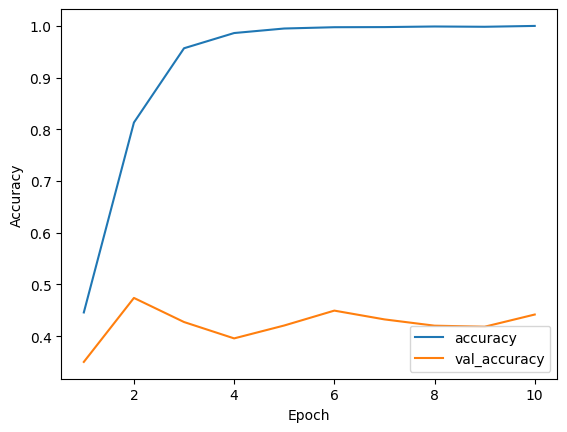

In [37]:
#plot de accuracy en validated accuracy
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## 5. Evaluation

## 6. Deployment